# Causal Learning

## Imports

In [140]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.network import BayesianNetwork
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score


In [2]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [124]:
from file_handler import FileHandler
import vis_seaborn as vs
from eda_helper import Helper
from df_overview import DfOverview


In [102]:
helper = Helper()

## Data reading

In [105]:
fh = FileHandler()
df = fh.read_csv("../data/data.csv")
df.head(5)


INFO:file_handler:Csv file read from ../data/data.csv.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.23,0.28,0.15,0.24,0.08,0.85,0.91,5.98,86.20,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,1937.05,0.16,0.63,0.71,0.27,0.42,0.12
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1937.05,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,86.20,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,M,11.42,20.38,77.58,386.10,0.13,0.23,0.24,0.11,0.25,0.08,0.50,1.16,3.44,27.23,0.01,0.06,0.06,0.02,0.04,0.01,14.91,26.50,98.87,567.70,0.19,0.63,0.69,0.26,0.42,0.12
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,86.20,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


IndexError: list index out of range

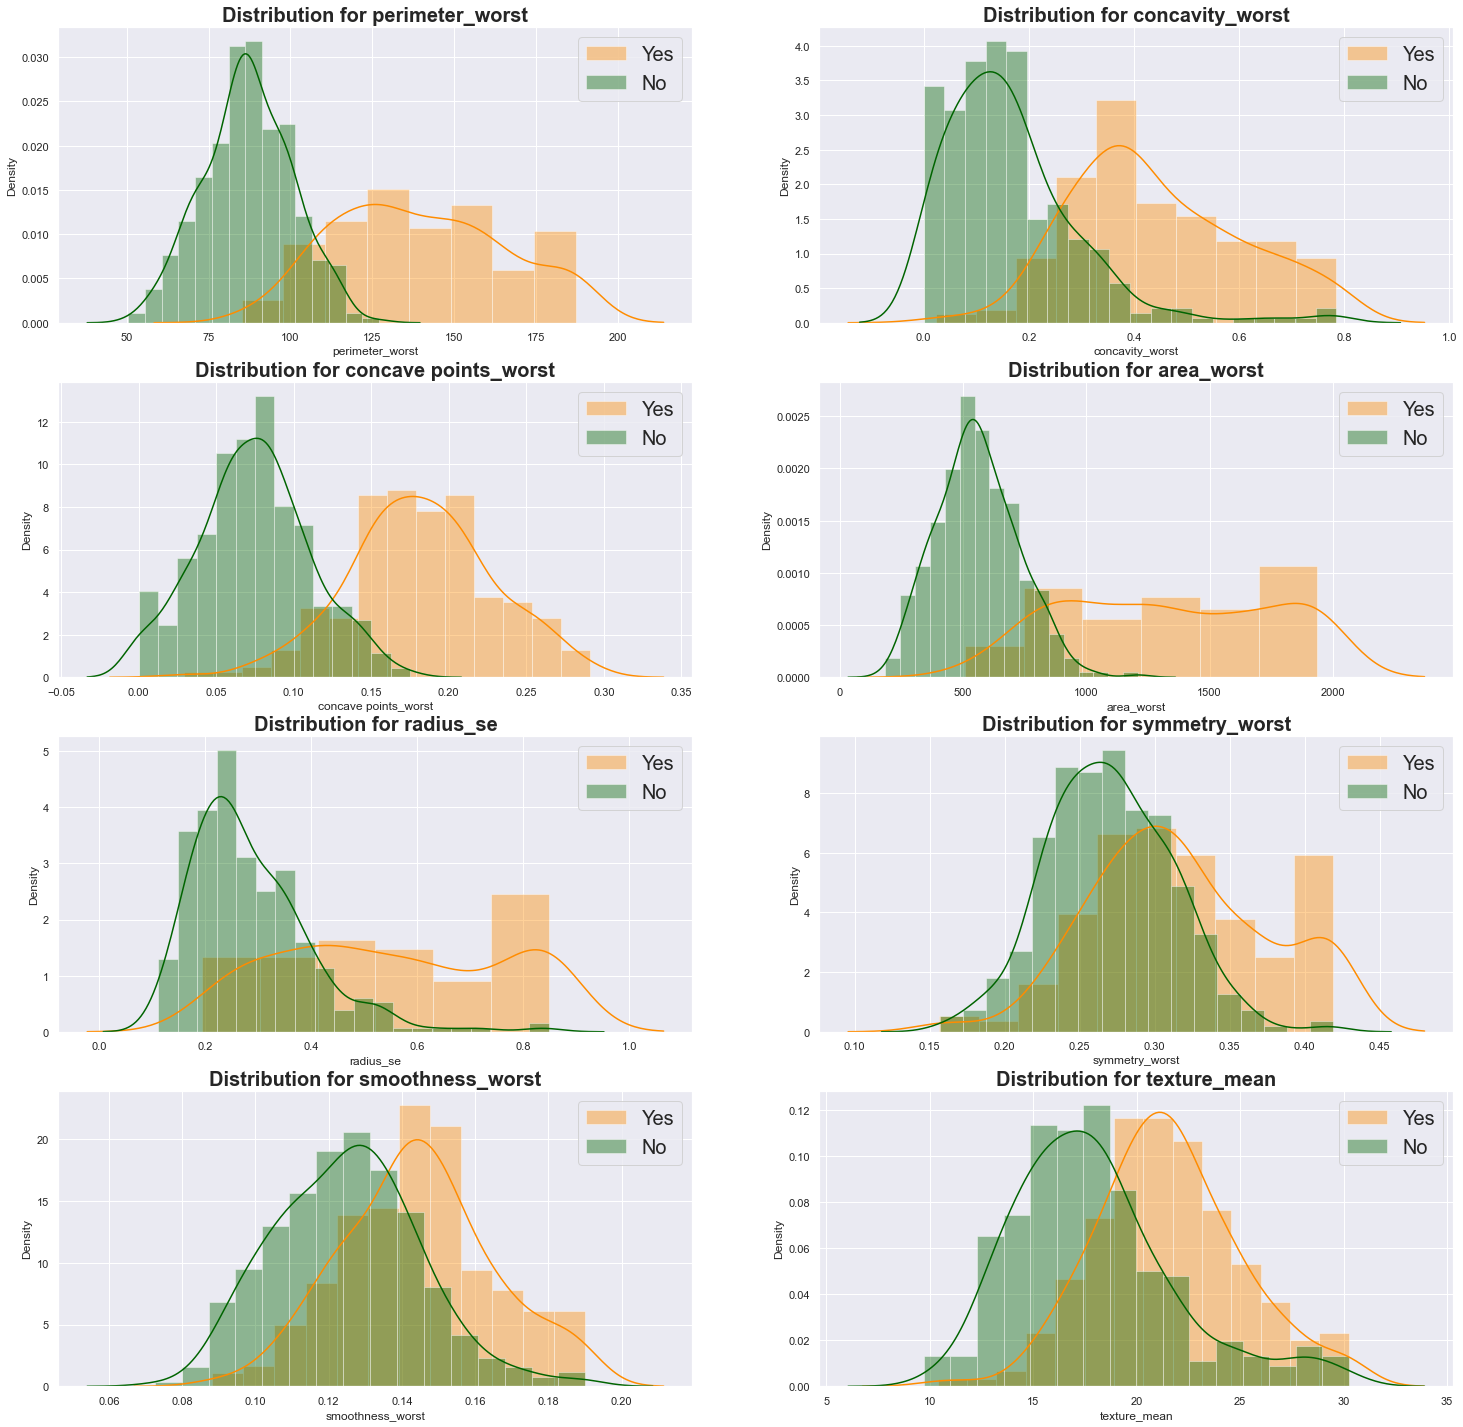

In [113]:
fig = plt.figure(figsize=(25, 25))
axs = [fig.add_subplot(4, 2, i + 1) for i in range(8)]

for i, column in enumerate(x.columns[1:]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i],
                 color='darkorange', label='Yes')
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i],
                 color='darkgreen', label='No')
    axs[i].set_title('Distribution for {}'.format(
        column), fontweight='bold', fontsize=20)
    axs[i].legend(fontsize=20)
plt.show()

ax = sns.distplot(x['diagnosis'], color='darkorange')
ax.set_title('Distribution for {}'.format(
    'Outcome'), fontweight='bold', fontsize=15)
plt.show()


In [106]:
x = df[['diagnosis',
        'perimeter_worst',
        'concavity_worst',
        'concave points_worst',
        'area_worst',
        'radius_se',
        'symmetry_worst',
        'smoothness_worst',
        'texture_mean',
        'concavity_mean']]


In [107]:
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)


In [108]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   diagnosis             569 non-null    int64  
 1   perimeter_worst       569 non-null    float64
 2   concavity_worst       569 non-null    float64
 3   concave points_worst  569 non-null    float64
 4   area_worst            569 non-null    float64
 5   radius_se             569 non-null    float64
 6   symmetry_worst        569 non-null    float64
 7   smoothness_worst      569 non-null    float64
 8   texture_mean          569 non-null    float64
 9   concavity_mean        569 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 44.6 KB


In [54]:
%%time
sm = from_pandas(x)

CPU times: user 2min 32s, sys: 1.75 s, total: 2min 34s
Wall time: 1min 26s


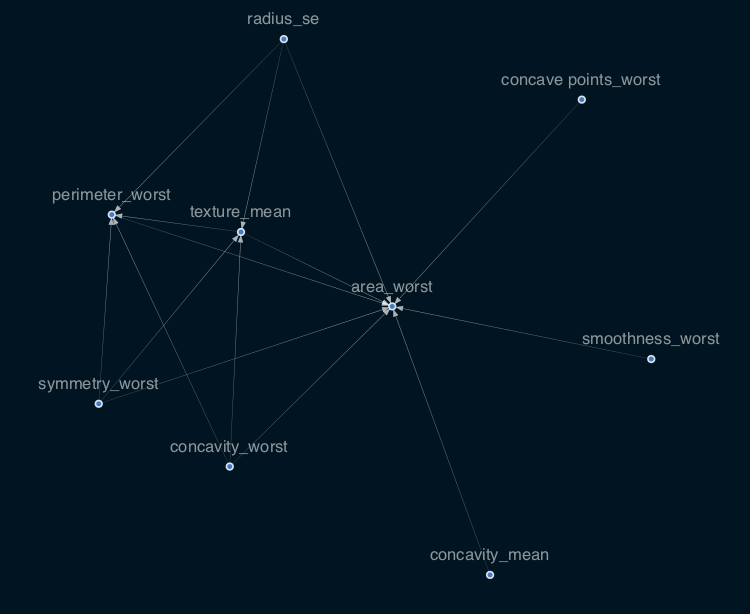

In [83]:
vis(sm)

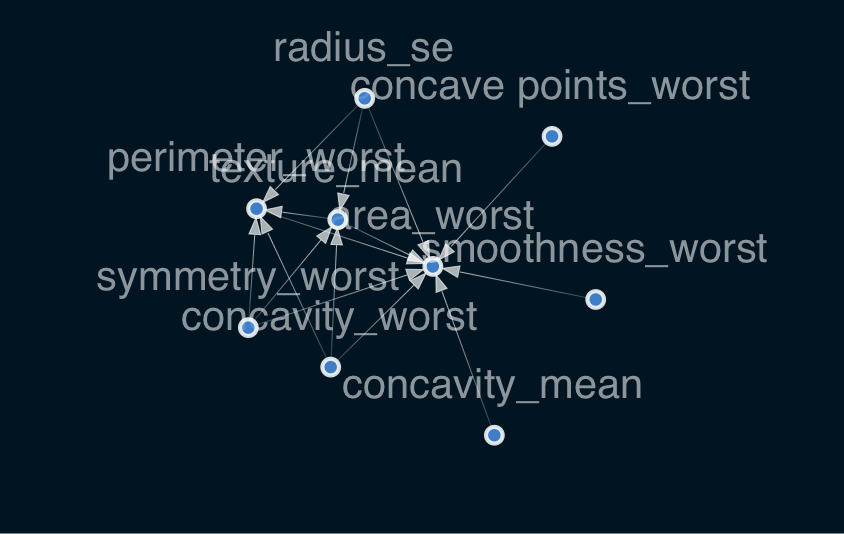

In [66]:
sm.remove_edges_below_threshold(0.8)
vis(sm)

## B

In [90]:
%%time
sm = from_pandas_lasso(x, tabu_parent_nodes=['diagnosis'], 
                          w_threshold=0.8, beta=0.8)

CPU times: user 55.8 s, sys: 798 ms, total: 56.6 s
Wall time: 35.6 s


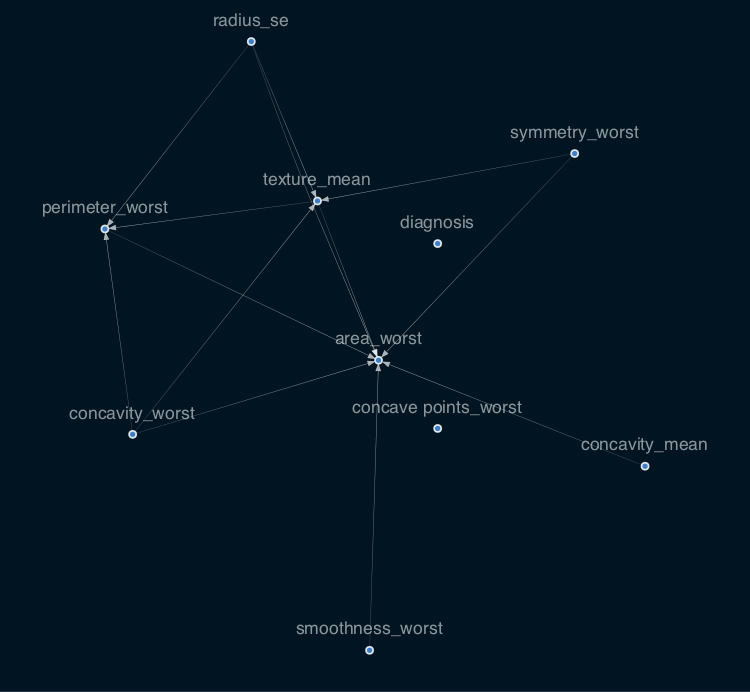

In [91]:
vis(sm)

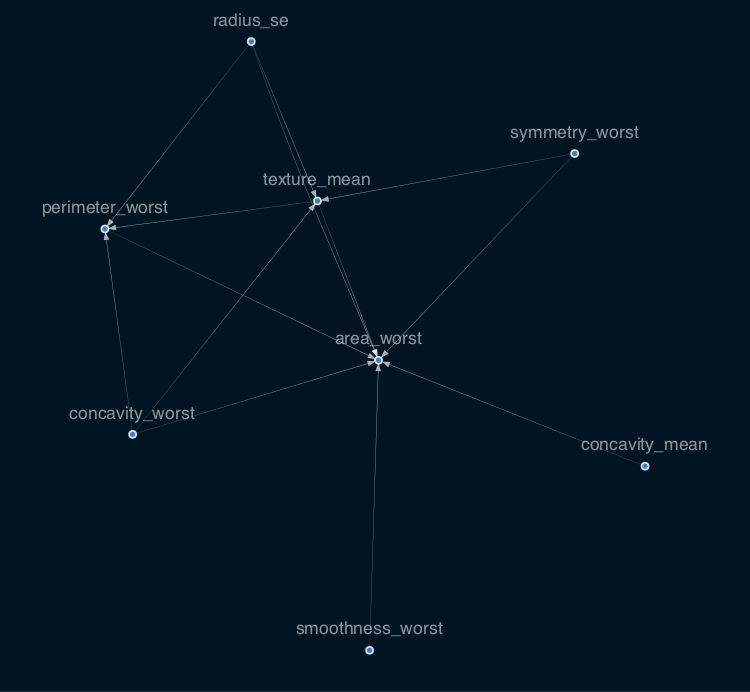

In [92]:
sm = sm.get_largest_subgraph()
vis(sm)

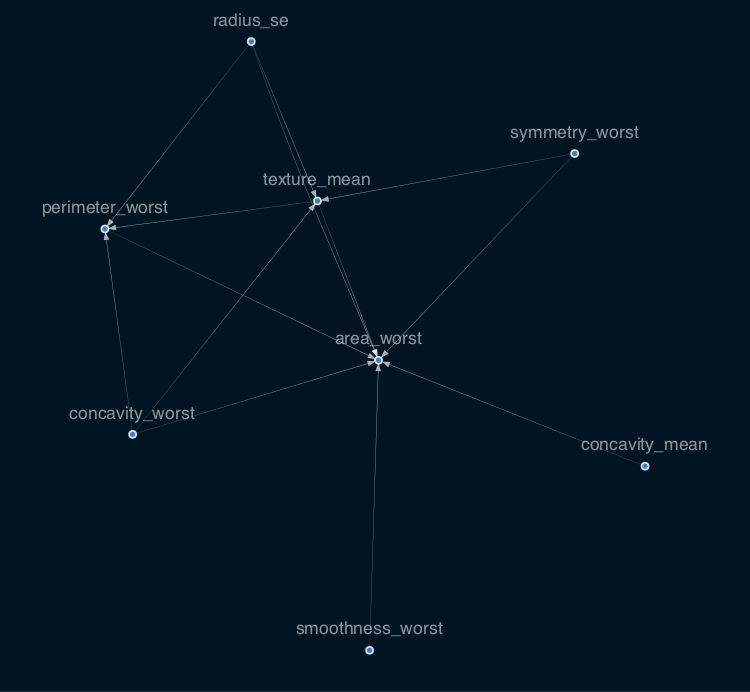

In [93]:
vis(sm)

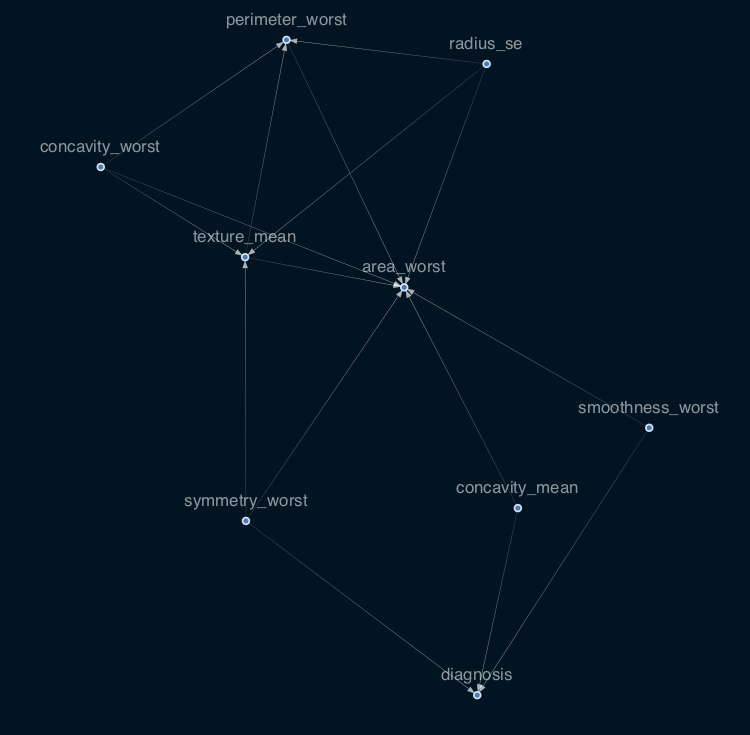

In [94]:
sm.add_edge("smoothness_worst", "diagnosis")
sm.add_edge("concavity_mean", "diagnosis")
sm.add_edge("symmetry_worst", "diagnosis")
vis(sm)


## Discretising Numeric Features

In [129]:
df_overview = DfOverview(x)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
                    ["count", "unique_value_count"])


,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,500,87.87%
2,CONCAVITY_WORST,569,528,92.79%
3,CONCAVE POINTS_WORST,569,492,86.47%
4,AREA_WORST,569,510,89.63%
5,RADIUS_SE,569,503,88.4%
6,SYMMETRY_WORST,569,478,84.01%
7,SMOOTHNESS_WORST,569,406,71.35%
8,TEXTURE_MEAN,569,473,83.13%
9,CONCAVITY_MEAN,569,520,91.39%


In [130]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   diagnosis             569 non-null    int64  
 1   perimeter_worst       569 non-null    float64
 2   concavity_worst       569 non-null    float64
 3   concave points_worst  569 non-null    float64
 4   area_worst            569 non-null    float64
 5   radius_se             569 non-null    float64
 6   symmetry_worst        569 non-null    float64
 7   smoothness_worst      569 non-null    float64
 8   texture_mean          569 non-null    float64
 9   concavity_mean        569 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 44.6 KB


In [133]:
from causalnex.discretiser import Discretiser

discretised_data = x.copy()
discretised_data["perimeter_worst"] = Discretiser(method="fixed", numeric_split_points=[1, 10]).transform(discretised_data["perimeter_worst"].values)
discretised_data["concavity_worst"] = Discretiser(method="fixed", numeric_split_points=[
                                                  1, 10]).transform(discretised_data["concavity_worst"].values)
discretised_data["concave points_worst"] = Discretiser(method="fixed", numeric_split_points=[
                                                       1, 10]).transform(discretised_data["concave points_worst"].values)
discretised_data["area_worst"] = Discretiser(method="fixed", numeric_split_points=[
                                             1, 10]).transform(discretised_data["area_worst"].values)
discretised_data["radius_se"] = Discretiser(method="fixed", numeric_split_points=[
                                            1, 10]).transform(discretised_data["radius_se"].values)
discretised_data["symmetry_worst"] = Discretiser(method="fixed", numeric_split_points=[
                                                 1, 10]).transform(discretised_data["symmetry_worst"].values)
discretised_data["smoothness_worst"] = Discretiser(method="fixed", numeric_split_points=[
                                                   1, 10]).transform(discretised_data["smoothness_worst"].values)
discretised_data["texture_mean"] = Discretiser(method="fixed", numeric_split_points=[
                                               1, 10]).transform(discretised_data["texture_mean"].values)
discretised_data["concavity_mean"] = Discretiser(method="fixed", numeric_split_points=[
                                                 1, 10]).transform(discretised_data["concavity_mean"].values)
discretised_data


,diagnosis,perimeter_worst,concavity_worst,concave points_worst,area_worst,radius_se,symmetry_worst,smoothness_worst,texture_mean,concavity_mean
0,1,2,0,0,2,0,0,0,2,0
1,1,2,0,0,2,0,0,0,2,0
2,1,2,0,0,2,0,0,0,2,0
3,1,2,0,0,2,0,0,0,2,0
4,1,2,0,0,2,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
564,1,2,0,0,2,0,0,0,2,0
565,1,2,0,0,2,0,0,0,2,0
566,1,2,0,0,2,0,0,0,2,0
567,1,2,0,0,2,0,0,0,2,0


## Bayesian Network

In [136]:
bn = BayesianNetwork(sm)
train, test = train_test_split(
    discretised_data, train_size=0.8, test_size=0.2, random_state=7)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [142]:
pred = bn.predict(test, 'diagnosis')
true = np.where(test['diagnosis'] == 'Yes', 1, 0)
pred = np.where(pred == 'Yes', 1, 0)
print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 0.00
F1: 0.00 
Accuracy: 1.00 
Precision: 0.00 
